## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

아래 코드는 1, 2번만 적용하고 3번은 적용하지 않은 2013년 버전 DQN

수렴이 느림

In [1]:
import gymnasium
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [2]:
class ReplayBuffer:
    Transition = collections.namedtuple('Transition', 'state action reward next_state terminated')

    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)
    
    def sample(self, batch_size):
        return self.Transition(*(torch.tensor(np.array(i)) for i in zip(*random.sample(self.memory, batch_size))))
    
    def append(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(
            np.array(state, dtype=np.float32),
            np.array(action, dtype=np.int64),
            np.array(reward, dtype=np.float32),
            np.array(next_state, dtype=np.float32),
            np.array(terminated, dtype=np.bool8),
        ))

    def __len__(self):
        return len(self.memory)

In [3]:
env = gymnasium.make('CartPole-v1')
hidden_size = 128
q = torch.nn.Sequential(
    torch.nn.Linear(*env.observation_space.shape, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, env.action_space.n)
)

In [4]:
lr = 0.0001
discount = 0.99
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(q.parameters(), lr=lr)
replay_buffer = ReplayBuffer(10000)
num_episodes = 600
batch_size = 128
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000

In [5]:
steps = []
action_count = 0
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    for step in itertools.count():
        eps = eps_end + (eps_start - eps_end) * math.exp(-action_count / eps_decay)
        action_count += 1
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = q(torch.tensor(state)).argmax().cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        replay_buffer.append(state, action, reward, next_state, terminated)
        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            state_action_values = q(batch.state).gather(1, batch.action.unsqueeze(1)).squeeze()
            next_state_values = torch.zeros_like(state_action_values)
            next_state_values[~batch.terminated] = q(batch.next_state[~batch.terminated]).max(1).values
            expected_state_action_values = next_state_values * discount + batch.reward
            loss = criterion(state_action_values, expected_state_action_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        state = next_state
        if terminated or truncated:
            break
    
    steps.append(step)

    if (i + 1) % 100 == 0:
        print(np.mean(steps[-100:]))

  0%|          | 0/600 [00:00<?, ?it/s]

 17%|█▋        | 100/600 [00:15<02:03,  4.05it/s]

20.11


 33%|███▎      | 200/600 [00:34<01:06,  5.99it/s]

29.99


 50%|█████     | 300/600 [00:59<01:26,  3.49it/s]

41.71


 67%|██████▋   | 400/600 [01:44<02:14,  1.48it/s]

71.45


 83%|████████▎ | 500/600 [03:47<03:40,  2.20s/it]

160.43


100%|██████████| 600/600 [09:23<00:00,  1.06it/s]

427.61


In [6]:
len(replay_buffer)

10000

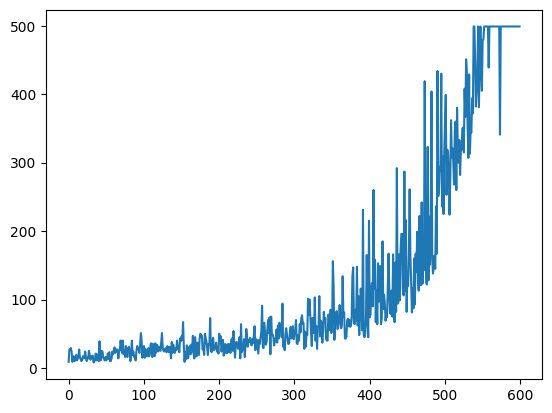

In [7]:
import matplotlib.pyplot as plt
plt.plot(steps)

In [8]:
env = gymnasium.make('CartPole-v1', render_mode='human')
scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = torch.argmax(q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        state = next_state
        if terminated or truncated:
            break
    scores.append(score)
env.close()
scores

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]

In [9]:
env.close()

In [10]:
env = gymnasium.make('CartPole-v1')